In [3]:
import models
import datasets
import torch.nn as nn
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
learning_rate =  25e-5
iterations = 50e3 
batch_size = 2
val_freq = 5000
net = models.RCNet.RCNet().cuda()
criterion_l1 = nn.SmoothL1Loss()
criterion_l2= nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,betas=(0.5,0.999))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                    milestones=[10e3,20e3,30e3], gamma=0.5)
train_dataset = datasets.webface_data.Webface_landmarks68()
test_dataset = datasets.helen_data.Helen()

In [ ]:
testset.__getitem__(5)[1]

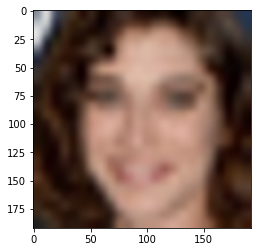

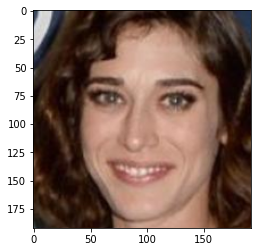

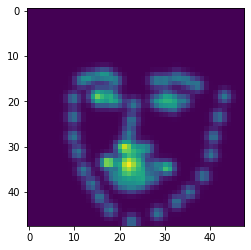

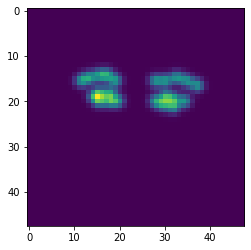

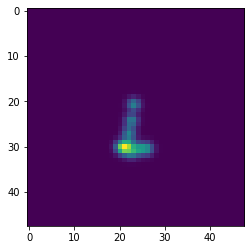

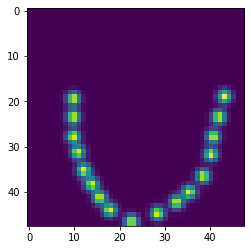

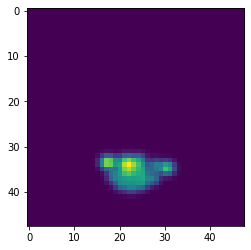

In [2]:
lr,hr,ld = train_dataset.__getitem__(5)
from matplotlib import pyplot as plt
plt.imshow(lr.permute(1,2,0))
plt.figure()
plt.imshow(hr.permute(1,2,0))
plt.figure()
plt.imshow(ld.sum(0))
land_fea = ld
eye_fea = land_fea[17:27].sum(axis = 0) + land_fea[36:48].sum(axis = 0)
nose_fea = land_fea[27:36].sum(axis = 0)
jaw_fea = land_fea[:17].sum(axis = 0)
mouth_fea = land_fea[48:68].sum(axis = 0)
plt.figure()
plt.imshow(eye_fea)
plt.figure()
plt.imshow(nose_fea)
plt.figure()
plt.imshow(jaw_fea)
plt.figure()
plt.imshow(mouth_fea)

In [4]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
writer = SummaryWriter('./logger')
# net.load_state_dict(torch.load('/home/zelin/csrnet/Baseline/RCNet/checkpoints/rcnet_005000.pt'))
train_data = DataLoader(train_dataset,batch_size = batch_size,shuffle=True,num_workers=8)
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)
step = 0
with tqdm(total=iterations) as pbar:
    while step<iterations:
        for i,data in enumerate(train_data):
            optimizer.zero_grad()
            lr,hr,lm = data
            lr = lr.float().cuda()
            hr = hr.float().cuda()
            lm = lm.float().cuda()
            coarse_sr,refine_sr,lds = net(lr)
            loss_coarse = [criterion_l2(sr,hr) for sr in coarse_sr]
            loss_refine = [criterion_l2(sr,hr) for sr in refine_sr]
            # loss_ld = [criterion_l1(F.interpolate(ld,(48,48)),lm) for ld in lds]
            loss_ld = [criterion_l1(ld,lm) for ld in lds]
            loss = 1*sum(loss_coarse)+1*sum(loss_ld)+1*sum(loss_refine)
            loss.backward()
            optimizer.step()
            step+=1
            scheduler.step()
            # pbar.set_description('')
            
            pbar.set_description('almost_zero:%f'%F.interpolate(lds[-1],(48,48)).sum())
            pbar.update(1)
            
            writer.add_scalar('l2_coarse',loss_coarse[-1], global_step=step, walltime=None)
            writer.add_scalar('l2_refine',loss_refine[-1], global_step=step, walltime=None)
            writer.add_scalar('l1_landm',loss_ld[-1], global_step=step, walltime=None)
            if step%5000 == 0:
                psnr = 0
                for j,test_ in enumerate(test_data):
                    net.eval()
                    lr,hr = test_
                    lr = lr.float().cuda()
                    hr = hr.float().cuda()
                    with torch.no_grad():
                        coarse_sr,refine_sr,lds = net(lr)
                        mse = ((refine_sr[-1]-hr)**2).mean(dim=[1,2,3])
                        psnr += (10*torch.log10(1/mse)).mean()
                net.train()
                writer.add_scalar('val_psnr',psnr/len(test_data), global_step=step, walltime=None)
                torch.save(net.state_dict(), '/home/zelin/csrnet/Baseline/RCNet/checkpoints/rcnet_%06d.pt'%step)
                writer.add_images('sr', refine_sr[-1], global_step=step, walltime=None, dataformats='NCHW')
                writer.add_images('ld', lds[-1].sum(1).unsqueeze(1), global_step=step, walltime=None, dataformats='NCHW')
            if step==iterations:
                break

almost_zero:0.000000:  31%|███       | 15289/50000.0 [3:02:27<6:54:15,  1.40it/s]  


KeyboardInterrupt: 

In [ ]:
psnr = 0
for j,test_ in enumerate(test_data):
    net.eval()
    lr,hr = test_
    lr = lr.float().cuda()
    hr = hr.float().cuda()
    with torch.no_grad():
        coarse_sr,refine_sr,lds = net(lr)
        mse = ((refine_sr[-1]-hr)**2).mean(dim=[1,2,3])
        psnr += (10*torch.log10(1/mse)).mean()

In [1]:
import models
import datasets
import torch.nn as nn
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
learning_rate = 25e-5
iterations = 50e3 
batch_size = 2
val_freq = 5000
net = models.RCNet.getheatmap().cuda()
criterion_l1 = nn.SmoothL1Loss()
criterion_l2= nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,betas=(0.5,0.999))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                    milestones=[10e3,20e3,30e3], gamma=0.5)
train_dataset = datasets.webface_data.Webface_landmarks68()
test_dataset = datasets.helen_data.Helen()

/home/zelin/anaconda3/envs/GFPGAN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
writer = SummaryWriter('./logger')
train_data = DataLoader(train_dataset,batch_size = batch_size,shuffle=True,num_workers=8)
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)
step = 0
with tqdm(total=iterations) as pbar:
    while step<iterations:
        for i,data in enumerate(train_data):
            optimizer.zero_grad()
            lr,hr,lm = data
            lr = lr.float().cuda()
            hr = hr.float().cuda()
            lm = lm.float().cuda()
            mid,lds,de,hou  = net(hr)
            
            loss = criterion_l1(F.interpolate(lds,(48,48)),lm)
            loss.backward()
            optimizer.step()
            step+=1
            scheduler.step()
            pbar.set_description('almost_zero:%f'%F.interpolate(lds,(48,48)).sum())
            pbar.update(1)
            writer.add_scalar('l1_landm',loss, global_step=step, walltime=None)
            writer.add_scalar('almost_zero',lds.sum(), global_step=step, walltime=None)
            if step%5000 == 0:
                psnr = 0
                net.eval()
                for j,test_ in enumerate(test_data):
                    
                    lr,hr = test_
                    lr = lr.float().cuda()
                    hr = hr.float().cuda()
                    with torch.no_grad():
                        mid,lds,de,hou  = net(hr)
                net.train()
                torch.save(net.state_dict(), '/home/zelin/csrnet/Baseline/RCNet/checkpoints/rcnet_hourglass_%06d.pt'%step)
                writer.add_images('ld', lds.sum(1).unsqueeze(1), global_step=step, walltime=None, dataformats='NCHW')
            if step==iterations:
                break

2023-04-08 02:52:06.776028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 02:52:07.537010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-08 02:52:07.537078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-08 02:52:07.537085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

ValueError: not enough values to unpack (expected 3, got 2)

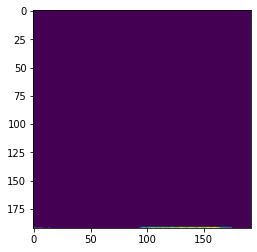

In [6]:
from matplotlib import pyplot as plt
plt.imshow(lds[0][0].detach().cpu().numpy().sum(0))

In [9]:
import models
import datasets
import torch.nn as nn
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
learning_rate = 0.00005
iterations = 50e3 
batch_size = 2
val_freq = 5000
net = models.RCNet.getheatmap_hou().cuda()
criterion_l1 = nn.SmoothL1Loss()
criterion_l2= nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,betas=(0.5,0.999))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                    milestones=[10e3,20e3,30e3], gamma=0.5)
train_dataset = datasets.webface_data.Webface_landmarks68()
test_dataset = datasets.helen_data.Helen()

In [14]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
writer = SummaryWriter('./logger')
train_data = DataLoader(train_dataset,batch_size = batch_size,shuffle=True,num_workers=8)
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)
step = 0
with tqdm(total=iterations) as pbar:
    while step<iterations:
        for i,data in enumerate(train_data):
            optimizer.zero_grad()
            lr,hr,lm = data
            lr = lr.float().cuda()
            hr = hr.float().cuda()
            lm = lm.float().cuda()
            mid,lds,de,hou  = net(F.interpolate(lr,(24,24)))
            
            loss = criterion_l1(F.interpolate(lds,(48,48)),lm)
            loss.backward()
            optimizer.step()
            step+=1
            scheduler.step()
            pbar.set_description('almost_zero:%f'%F.interpolate(lds,(48,48)).sum())
            pbar.update(1)
            writer.add_scalar('l1_landm',loss, global_step=step, walltime=None)
            writer.add_scalar('almost_zero',lds.sum(), global_step=step, walltime=None)
            if step%5000 == 0:
                psnr = 0
                net.eval()
                for j,test_ in enumerate(test_data):
                    
                    lr,hr = test_
                    lr = lr.float().cuda()
                    hr = hr.float().cuda()
                    with torch.no_grad():
                        mid,lds,de,hou  = net(F.interpolate(lr,(24,24)))
                net.train()
                torch.save(net.state_dict(), '/home/zelin/csrnet/Baseline/RCNet/checkpoints/rcnet_hourglass_%06d.pt'%step)
                writer.add_images('ld', lds.sum(1).unsqueeze(1), global_step=step, walltime=None, dataformats='NCHW')
            if step==iterations:
                break

almost_zero:817.339661:  11%|█         | 5272/50000.0 [03:58<33:46, 22.07it/s]  


KeyboardInterrupt: 

In [1]:
net

NameError: name 'net' is not defined

In [4]:
F.interpolate(lr,(24,24))

tensor([[[[0.8706, 0.8902, 0.8863,  ..., 0.3843, 0.6196, 0.7216],
          [0.8902, 0.8941, 0.8784,  ..., 0.3373, 0.5255, 0.6941],
          [0.8863, 0.8784, 0.8588,  ..., 0.2941, 0.3686, 0.5882],
          ...,
          [0.7176, 0.5922, 0.3412,  ..., 0.2314, 0.2471, 0.3216],
          [0.6353, 0.6157, 0.4353,  ..., 0.2196, 0.2314, 0.4078],
          [0.4824, 0.5608, 0.5216,  ..., 0.2157, 0.2588, 0.5020]],

         [[0.9020, 0.9137, 0.9059,  ..., 0.2431, 0.5490, 0.7059],
          [0.9137, 0.9137, 0.9020,  ..., 0.1843, 0.4118, 0.6588],
          [0.9098, 0.9020, 0.8824,  ..., 0.1490, 0.2118, 0.5020],
          ...,
          [0.4471, 0.3098, 0.1490,  ..., 0.1333, 0.1373, 0.1686],
          [0.3294, 0.3020, 0.2000,  ..., 0.1294, 0.1216, 0.2980],
          [0.2039, 0.2745, 0.2588,  ..., 0.1294, 0.1333, 0.3961]],

         [[0.8118, 0.8235, 0.8157,  ..., 0.2078, 0.4745, 0.6196],
          [0.8235, 0.8235, 0.8078,  ..., 0.1686, 0.3608, 0.5843],
          [0.8157, 0.8078, 0.7922,  ..., 0

In [ ]:
data = train_dataset.__getitem__(10)
lr,hr,lm = data


In [ ]:
lm[0]

In [ ]:

i += 1
data = train_dataset.__getitem__(i)
lr,hr,lm = data

from matplotlib import pyplot as plt
plt.imshow(lm.sum(0))
fig = plt.figure()
plt.imshow(lr.permute(1,2,0).numpy())

In [ ]:
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)
net.load_state_dict(torch.load('/home/zelin/csrnet/Baseline/RCNet/checkpoints/rcnet_hourglass_005000.pt'))

In [ ]:
for j,test_ in enumerate(test_data):
    net.eval()
    lr,hr = test_
    lr = lr.float().cuda()
    hr = hr.float().cuda()
    with torch.no_grad():
        mid,lds,de,hou = net(lr)

In [ ]:
F.interpolate(lds,(48,48)).sum()

In [15]:
lds[0]

tensor([[[ 2.4077e-03,  1.0164e-03,  2.5093e-03,  ..., -9.6730e-03,
           1.7162e-03, -8.9737e-03],
         [ 2.1159e-03, -1.1323e-03,  2.8366e-03,  ..., -9.3335e-03,
          -4.2679e-04, -1.4859e-02],
         [ 2.1067e-03,  2.4638e-06,  2.2394e-03,  ..., -6.2140e-03,
           7.9766e-04, -1.0050e-02],
         ...,
         [-1.5697e-02, -8.4025e-03, -1.0227e-02,  ..., -1.6603e-02,
          -1.3627e-04, -1.2143e-02],
         [ 1.8115e-03, -5.9357e-03,  1.5955e-03,  ..., -1.9648e-02,
           1.0157e-03, -1.0004e-02],
         [ 4.8958e-02, -2.2902e-03, -3.1519e-02,  ...,  1.7568e-02,
           2.3064e-03, -8.6828e-02]],

        [[ 2.9524e-03,  3.2578e-03,  2.8493e-03,  ...,  1.8756e-03,
           3.1607e-03,  2.0960e-02],
         [ 1.7966e-02,  3.7938e-03,  5.2873e-03,  ...,  9.8477e-03,
           3.7968e-03,  5.7101e-03],
         [ 2.8561e-03,  3.4453e-03,  2.9893e-03,  ...,  7.7260e-03,
           3.2828e-03,  2.3020e-02],
         ...,
         [-1.6384e-02,  9

In [ ]:
F.interpolate(lds,(32,32)).detach().cpu().numpy().sum(0)/255.*100

In [6]:
lds[0].detach().cpu().numpy().sum(0).shape

(68, 192, 192)

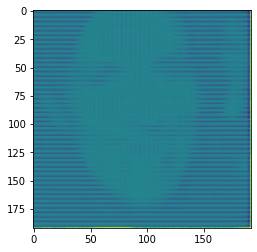

In [13]:
from matplotlib import pyplot as plt
plt.imshow(lds[0][0].detach().cpu().numpy().sum(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


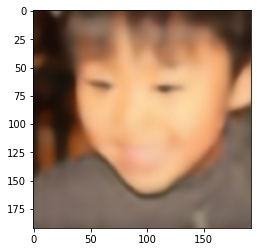

In [25]:
from matplotlib import pyplot as plt
plt.imshow(coarse_sr[-1][1].permute(1,2,0).detach().cpu().numpy())

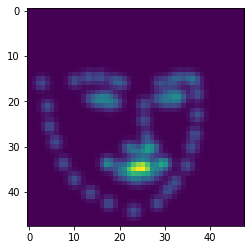

In [17]:
plt.imshow(lm[0].detach().cpu().numpy().sum(0))

In [ ]:
for l in lds[1]:
    print(l.sum())

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(F.interpolate(lds,(48,48))[1].detach().cpu().numpy().sum(0))

In [ ]:
lds[-1][1].sum()

In [ ]:
lds[-1][1].detach().cpu().numpy().sum()

In [ ]:
lds[-1].sum(1).unsqueeze(1).shape

In [ ]:
from matplotlib import pyplot as plt
lm[0].detach().cpu().numpy().sum(0).s

In [ ]:
(lm[0]==0.0).sum()/(192*192*68)

In [ ]:
plt.imshow(lm[0].detach().cpu().numpy().sum(0))

In [ ]:
plt.imshow(refine_sr[0][0].permute(1,2,0).detach().cpu().numpy())

In [ ]:
plt.imshow(lr[0].permute(1,2,0).detach().cpu().numpy())

In [ ]:
coarse_sr[0].shape

In [ ]:
(abs(lm[0].detach().cpu().numpy())).mean()

In [ ]:
lds[-1][0].sum()

In [ ]:
plt.imshow(coarse_sr[-1][1].permute(1,2,0).detach().cpu().numpy())